# Applied Data Science 2 - Keras Assignment - 2023A

In this assignment you will be building a script to classify movie posters. The assignment is broken up into sections and you need to complete each section successively. The sections are:

1. Data Processing
2. Model Definition
3. Model Training
4. Model Evaluation

In addition to this coding exercise, you will also need to write a 1-2 page report analysing and critically evaluating you models results.

In [1]:
# Enter your module imports here, some modules are already provided

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
import pandas as pd
from sklearn import model_selection

In [2]:
# CodeGrade Tag Init1
# Do not edit, remove, or copy this cell

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Processing



In [3]:
# CodeGrade Tag Init2
# Do not edit, remove, or copy this cell

# This code will copy the images from your google drive into the colab file
# storage. Make sure the dataset is unzipped in your drive folder.
! mkdir /tmp/Multi_Label_dataset
! rsync -ah --info=progress2 /content/drive/MyDrive/Multi_Label_dataset/Images /tmp/Multi_Label_dataset/

mkdir: cannot create directory ‘/tmp/Multi_Label_dataset’: File exists
              0   0%    0.00kB/s    0:00:00 (xfr#0, to-chk=0/7874)   


In [4]:
# CodeGrade Tag DataProc
# Do not edit, remove, or copy this cell

# Load the csv with the sample IDs and genres
csv_loc = "/content/drive/MyDrive/Multi_Label_dataset/train.csv"
dataset = pd.read_csv("/content/drive/MyDrive/Multi_Label_dataset/train.csv")

# Split the dataset into training and testing
data_train, data_test = model_selection.train_test_split(dataset, test_size=0.2)

# Convert the labels to arrays
labels_train = np.array(data_train.drop(['Id', 'Genre'],axis=1)).astype('float32')
labels_test = np.array(data_test.drop(['Id', 'Genre'],axis=1)).astype('float32')

# List of the genre names
genres = np.array(data_train.drop(['Id', 'Genre'],axis=1).columns)

# Build the file locations for the images
img_loc = "/tmp/Multi_Label_dataset/Images"

img_locs_train = np.array([[img_loc + '/' + id + '.jpg' for id in data_train['Id']]])
img_locs_test = [[img_loc + '/' + id + '.jpg' for id in data_test['Id']]]


# This function is provided to read in the image files from the folder
def parse_image(filename, label):
  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  return image, label

# Create the initial datasets
train_list_ds = tf.data.Dataset.from_tensor_slices((img_locs_train[0], labels_train))
test_list_ds = tf.data.Dataset.from_tensor_slices((img_locs_test[0], labels_test))

**Create a function called "img_process" converts the images to float32 datatype and resizes them to 64x64 pixels.**

In [5]:
# CodeGrade Tag Ex1a
### Write a function called img_process, which takes in the image and label as
### inputs, converts the data type of the image to tf.float32, resizes the
### image to (64, 64), and finally returns the image and labels.


def img_process(filename, label):
    # Read and decode the image
    image = tf.io.read_file(filename)
    image = tf.io.decode_jpeg(image, channels=3)
    # Resize and normalize the image
    image = tf.image.resize(image, (64, 64))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image, label


**Using the tf.data API, load in the training and validation data. Be mindful of efficient data processing good practice to minimise the time it takes to load the data.**

In [6]:
# CodeGrade Tag Ex1b
### Use the parse_image and img_process functions to construct the training and
### validation datasets. You should utilise good practice in optimising the
### dataset loading. Use a batch size of 64. Use techniques like caching and
### prefetching to efficiently load the data.

batch_size = 64

# Shuffle and preprocess the training data
train_ds = (
    train_list_ds
    .shuffle(buffer_size=len(train_list_ds))
    .map(img_process, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

# Preprocess the testing data
test_ds = (
    test_list_ds
    .map(img_process, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)


# Model Definition

**Using the Keras Functional API, create a convolutional neural network with the architecture show in the model summary below.**

**A few important points to consider:**

* Call the convolutional layers and the first dense layer should have ReLU activation functions. The output layer should have a Sigmoid activation function.
* Pay attention to the output shapes and the number of partmeters for each layer, as these give indications as to the correct settings for the number of filters, kernel size, stride length and padding.
* Use the layer names provided in the summary in your model.
* For the dropout layers, use a dropout rate of 0.2 after the convolutional layers and 0.5 after the dense layers.


```
# Model Summary

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 Input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 Conv0 (Conv2D)              (None, 32, 32, 16)        448       
                                                                 
 Drop1 (Dropout)             (None, 32, 32, 16)        0         
                                                                 
 Conv1 (Conv2D)              (None, 32, 32, 32)        4640      
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 Drop2 (Dropout)             (None, 32, 32, 32)        0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 Conv3 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 Conv4 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 Drop3 (Dropout)             (None, 16, 16, 64)        0         
                                                                 
 Pool2 (MaxPooling2D)        (None, 8, 8, 64)          0         
                                                                 
 Conv5 (Conv2D)              (None, 8, 8, 128)         73856     
                                                                 
 Conv6 (Conv2D)              (None, 8, 8, 128)         147584    
                                                                 
 Drop4 (Dropout)             (None, 8, 8, 128)         0         
                                                                 
 Pool3 (MaxPooling2D)        (None, 4, 4, 128)         0         
                                                                 
 Flat (Flatten)              (None, 2048)              0         
                                                                 
 FC1 (Dense)                 (None, 1024)              2098176   
                                                                 
 Drop5 (Dropout)             (None, 1024)              0         
                                                                 
 FC2 (Dense)                 (None, 1024)              1049600   
                                                                 
 Drop6 (Dropout)             (None, 1024)              0         
                                                                 
 Output (Dense)              (None, 25)                25625     
                                                                 
=================================================================
Total params: 3464601 (13.22 MB)
Trainable params: 3464601 (13.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


```



In [7]:
# CodeGrade Tag Ex2a
### Define the model using the Keras Functional API. Use the summary above as a
### guide for the model parameters. You will need to define the filters/units of
### the layers correctly, as well as the kernel size, stride length and padding
### of the convolutional layers.

# Define the model architecture
inputs = keras.Input(shape=(64, 64, 3), name="Input")
x = keras.layers.Conv2D(16, 3, activation='relu', name="Conv0")(inputs)
x = keras.layers.Dropout(0.2, name="Drop1")(x)
x = keras.layers.Conv2D(32, 3, activation='relu', name="Conv1")(x)
x = keras.layers.Conv2D(32, 3, activation='relu', name="Conv2")(x)
x = keras.layers.Dropout(0.2, name="Drop2")(x)
x = keras.layers.MaxPooling2D(2, name="Pool1")(x)
x = keras.layers.Conv2D(64, 3, activation='relu', name="Conv3")(x)
x = keras.layers.Conv2D(64, 3, activation='relu', name="Conv4")(x)
x = keras.layers.Dropout(0.2, name="Drop3")(x)
x = keras.layers.MaxPooling2D(2, name="Pool2")(x)
x = keras.layers.Conv2D(128, 3, activation='relu', name="Conv5")(x)
x = keras.layers.Conv2D(128, 3, activation='relu', name="Conv6")(x)
x = keras.layers.Dropout(0.2, name="Drop4")(x)
x = keras.layers.MaxPooling2D(2, name="Pool3")(x)
x = keras.layers.Flatten(name="Flat")(x)
x = keras.layers.Dense(1024, activation='relu', name="FC1")(x)
x = keras.layers.Dropout(0.5, name="Drop5")(x)
x = keras.layers.Dense(1024, activation='relu', name="FC2")(x)
x = keras.layers.Dropout(0.5, name="Drop6")(x)
outputs = keras.layers.Dense(25, activation='sigmoid', name="Output")(x)

# Create the model
model = keras.Model(inputs=inputs, outputs=outputs, name="movie_poster_classifier")



In [8]:
# CodeGrade Tag Ex2b
### Print the model summary and confirm is has the same architecture as the one
### provided.

model.summary()


Model: "movie_poster_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 Conv0 (Conv2D)              (None, 62, 62, 16)        448       
                                                                 
 Drop1 (Dropout)             (None, 62, 62, 16)        0         
                                                                 
 Conv1 (Conv2D)              (None, 60, 60, 32)        4640      
                                                                 
 Conv2 (Conv2D)              (None, 58, 58, 32)        9248      
                                                                 
 Drop2 (Dropout)             (None, 58, 58, 32)        0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 29, 29,

**Compile the model using the Adam Optimizer with a learning rate of ```1e-4``` and ```binary crossentropy``` loss function. For the metrics, use the ``Precision`` and ``Recall`` functions.**

In [9]:
# CodeGrade Tag Ex2c
### Compile the model using the Adam Optimizer, binary crossentropy loss, and
### precision and recall metrics.

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=[keras.metrics.Precision(), keras.metrics.Recall()])


# Model Training

**Create a Model Checkpoint Callback that saves the weights of the best performing epoch, based on the validation accuracy.**

In [10]:
# CodeGrade Tag Ex3a
### Create a ModelCheckpoint callback to store the bext weights from the model,
### based on the validation accuracy. Call this callback "checkpoint_callback"

checkpoint_filepath = '/content/checkpoint'
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                      save_weights_only=True,
                                                      monitor='val_accuracy',
                                                      mode='max',
                                                      save_best_only=True)


**Create a Learning Rate Scheduler Callback that utilises the provided function to decrease the learning rate during training.**

In [11]:
# CodeGrade Tag Ex3b
### Using the function provided, create a LearningRateScheduler callback, call
### it "lr_callback"

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.01)

lr_callback = keras.callbacks.LearningRateScheduler(scheduler)


**Train the model for 40 epochs, using the callbacks you made previously. Store the losses and metrics to use later.**

In [12]:
# CodeGrade Tag Ex3c
### Train the model for 40 epochs, using the callbacks you have created. Store
### the losses and metrics in a history object.

history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=40,
                    callbacks=[checkpoint_callback, lr_callback])



Epoch 1/40
91/91 [==============================] - ETA: 0s - loss: 0.3240 - precision: 0.3041 - recall: 0.1932

91/91 [==============================] - 23s 68ms/step - loss: 0.3240 - precision: 0.3041 - recall: 0.1932 - val_loss: 0.3548 - val_precision: 0.5100 - val_recall: 0.2191 - lr: 1.0000e-04
Epoch 2/40
90/91 [============================>.] - ETA: 0s - loss: 0.2595 - precision: 0.4775 - recall: 0.1668

91/91 [==============================] - 4s 43ms/step - loss: 0.2593 - precision: 0.4776 - recall: 0.1670 - val_loss: 0.3235 - val_precision: 0.5293 - val_recall: 0.1069 - lr: 1.0000e-04
Epoch 3/40
91/91 [==============================] - ETA: 0s - loss: 0.2526 - precision: 0.4879 - recall: 0.1727

91/91 [==============================] - 4s 44ms/step - loss: 0.2526 - precision: 0.4879 - recall: 0.1727 - val_loss: 0.3165 - val_precision: 0.5222 - val_recall: 0.2614 - lr: 1.0000e-04
Epoch 4/40
90/91 [============================>.] - ETA: 0s - loss: 0.2480 - precision: 0.5118 - recall: 0.1798

91/91 [==============================] - 6s 63ms/step - loss: 0.2479 - precision: 0.5122 - recall: 0.1801 - val_loss: 0.2960 - val_precision: 0.5739 - val_recall: 0.0782 - lr: 1.0000e-04
Epoch 5/40
91/91 [==============================] - ETA: 0s - loss: 0.2459 - precision: 0.5056 - recall: 0.1806

91/91 [==============================] - 4s 44ms/step - loss: 0.2459 - precision: 0.5056 - recall: 0.1806 - val_loss: 0.3016 - val_precision: 0.5566 - val_recall: 0.1193 - lr: 1.0000e-04
Epoch 6/40
90/91 [============================>.] - ETA: 0s - loss: 0.2444 - precision: 0.5253 - recall: 0.1880

91/91 [==============================] - 4s 43ms/step - loss: 0.2445 - precision: 0.5251 - recall: 0.1882 - val_loss: 0.3014 - val_precision: 0.5653 - val_recall: 0.2075 - lr: 1.0000e-04
Epoch 7/40
91/91 [==============================] - ETA: 0s - loss: 0.2437 - precision: 0.5285 - recall: 0.1895

91/91 [==============================] - 6s 64ms/step - loss: 0.2437 - precision: 0.5285 - recall: 0.1895 - val_loss: 0.2893 - val_precision: 0.5449 - val_recall: 0.2445 - lr: 1.0000e-04
Epoch 8/40
90/91 [============================>.] - ETA: 0s - loss: 0.2429 - precision: 0.5270 - recall: 0.1902

91/91 [==============================] - 6s 67ms/step - loss: 0.2427 - precision: 0.5278 - recall: 0.1906 - val_loss: 0.2800 - val_precision: 0.5277 - val_recall: 0.2282 - lr: 1.0000e-04
Epoch 9/40
90/91 [============================>.] - ETA: 0s - loss: 0.2413 - precision: 0.5367 - recall: 0.1940

91/91 [==============================] - 5s 51ms/step - loss: 0.2414 - precision: 0.5366 - recall: 0.1941 - val_loss: 0.2839 - val_precision: 0.5617 - val_recall: 0.1631 - lr: 1.0000e-04
Epoch 10/40
90/91 [============================>.] - ETA: 0s - loss: 0.2405 - precision: 0.5385 - recall: 0.2020

91/91 [==============================] - 5s 50ms/step - loss: 0.2404 - precision: 0.5406 - recall: 0.2024 - val_loss: 0.2727 - val_precision: 0.6064 - val_recall: 0.1468 - lr: 1.0000e-04
Epoch 11/40
90/91 [============================>.] - ETA: 0s - loss: 0.2409 - precision: 0.5441 - recall: 0.1939

91/91 [==============================] - 9s 97ms/step - loss: 0.2406 - precision: 0.5452 - recall: 0.1945 - val_loss: 0.2737 - val_precision: 0.6198 - val_recall: 0.1018 - lr: 9.9005e-05
Epoch 12/40
90/91 [============================>.] - ETA: 0s - loss: 0.2389 - precision: 0.5591 - recall: 0.2044

91/91 [==============================] - 4s 47ms/step - loss: 0.2388 - precision: 0.5593 - recall: 0.2044 - val_loss: 0.2635 - val_precision: 0.5684 - val_recall: 0.1279 - lr: 9.8020e-05
Epoch 13/40
90/91 [============================>.] - ETA: 0s - loss: 0.2383 - precision: 0.5576 - recall: 0.2065

91/91 [==============================] - 4s 43ms/step - loss: 0.2383 - precision: 0.5573 - recall: 0.2064 - val_loss: 0.2709 - val_precision: 0.5991 - val_recall: 0.1234 - lr: 9.7045e-05
Epoch 14/40
91/91 [==============================] - ETA: 0s - loss: 0.2379 - precision: 0.5642 - recall: 0.2064

91/91 [==============================] - 6s 64ms/step - loss: 0.2379 - precision: 0.5642 - recall: 0.2064 - val_loss: 0.2761 - val_precision: 0.6004 - val_recall: 0.0938 - lr: 9.6079e-05
Epoch 15/40
91/91 [==============================] - ETA: 0s - loss: 0.2368 - precision: 0.5690 - recall: 0.2122

91/91 [==============================] - 4s 43ms/step - loss: 0.2368 - precision: 0.5690 - recall: 0.2122 - val_loss: 0.2746 - val_precision: 0.6283 - val_recall: 0.1421 - lr: 9.5123e-05
Epoch 16/40
91/91 [==============================] - ETA: 0s - loss: 0.2369 - precision: 0.5700 - recall: 0.2056

91/91 [==============================] - 4s 43ms/step - loss: 0.2369 - precision: 0.5700 - recall: 0.2056 - val_loss: 0.2726 - val_precision: 0.5893 - val_recall: 0.1338 - lr: 9.4176e-05
Epoch 17/40
91/91 [==============================] - ETA: 0s - loss: 0.2354 - precision: 0.5804 - recall: 0.2168

91/91 [==============================] - 6s 61ms/step - loss: 0.2354 - precision: 0.5804 - recall: 0.2168 - val_loss: 0.2665 - val_precision: 0.5758 - val_recall: 0.1631 - lr: 9.3239e-05
Epoch 18/40
90/91 [============================>.] - ETA: 0s - loss: 0.2350 - precision: 0.5863 - recall: 0.2121

91/91 [==============================] - 4s 44ms/step - loss: 0.2349 - precision: 0.5861 - recall: 0.2121 - val_loss: 0.2564 - val_precision: 0.5695 - val_recall: 0.1832 - lr: 9.2312e-05
Epoch 19/40
91/91 [==============================] - ETA: 0s - loss: 0.2340 - precision: 0.5932 - recall: 0.2164

91/91 [==============================] - 4s 44ms/step - loss: 0.2340 - precision: 0.5932 - recall: 0.2164 - val_loss: 0.2670 - val_precision: 0.5176 - val_recall: 0.2007 - lr: 9.1393e-05
Epoch 20/40
91/91 [==============================] - ETA: 0s - loss: 0.2336 - precision: 0.6021 - recall: 0.2241

91/91 [==============================] - 7s 72ms/step - loss: 0.2336 - precision: 0.6021 - recall: 0.2241 - val_loss: 0.2639 - val_precision: 0.5532 - val_recall: 0.1448 - lr: 9.0484e-05
Epoch 21/40
89/91 [============================>.] - ETA: 0s - loss: 0.2328 - precision: 0.6069 - recall: 0.2215

91/91 [==============================] - 4s 44ms/step - loss: 0.2326 - precision: 0.6062 - recall: 0.2215 - val_loss: 0.2559 - val_precision: 0.5349 - val_recall: 0.1859 - lr: 8.9583e-05
Epoch 22/40
91/91 [==============================] - ETA: 0s - loss: 0.2310 - precision: 0.6095 - recall: 0.2211

91/91 [==============================] - 6s 65ms/step - loss: 0.2310 - precision: 0.6095 - recall: 0.2211 - val_loss: 0.2656 - val_precision: 0.5381 - val_recall: 0.1841 - lr: 8.8692e-05
Epoch 23/40
91/91 [==============================] - ETA: 0s - loss: 0.2310 - precision: 0.6116 - recall: 0.2244

91/91 [==============================] - 4s 43ms/step - loss: 0.2310 - precision: 0.6116 - recall: 0.2244 - val_loss: 0.2585 - val_precision: 0.5399 - val_recall: 0.1901 - lr: 8.7810e-05
Epoch 24/40
90/91 [============================>.] - ETA: 0s - loss: 0.2292 - precision: 0.6234 - recall: 0.2305

91/91 [==============================] - 6s 60ms/step - loss: 0.2293 - precision: 0.6238 - recall: 0.2304 - val_loss: 0.2637 - val_precision: 0.5461 - val_recall: 0.1720 - lr: 8.6936e-05
Epoch 25/40
90/91 [============================>.] - ETA: 0s - loss: 0.2289 - precision: 0.6316 - recall: 0.2306

91/91 [==============================] - 5s 51ms/step - loss: 0.2290 - precision: 0.6320 - recall: 0.2309 - val_loss: 0.2585 - val_precision: 0.5317 - val_recall: 0.1862 - lr: 8.6071e-05
Epoch 26/40
90/91 [============================>.] - ETA: 0s - loss: 0.2279 - precision: 0.6212 - recall: 0.2342

91/91 [==============================] - 5s 55ms/step - loss: 0.2280 - precision: 0.6214 - recall: 0.2341 - val_loss: 0.2629 - val_precision: 0.5537 - val_recall: 0.1800 - lr: 8.5214e-05
Epoch 27/40
91/91 [==============================] - ETA: 0s - loss: 0.2265 - precision: 0.6428 - recall: 0.2375

91/91 [==============================] - 4s 43ms/step - loss: 0.2265 - precision: 0.6428 - recall: 0.2375 - val_loss: 0.2567 - val_precision: 0.5395 - val_recall: 0.1960 - lr: 8.4366e-05
Epoch 28/40
91/91 [==============================] - ETA: 0s - loss: 0.2258 - precision: 0.6466 - recall: 0.2451

91/91 [==============================] - 5s 50ms/step - loss: 0.2258 - precision: 0.6466 - recall: 0.2451 - val_loss: 0.2630 - val_precision: 0.5865 - val_recall: 0.1726 - lr: 8.3527e-05
Epoch 29/40
91/91 [==============================] - ETA: 0s - loss: 0.2249 - precision: 0.6400 - recall: 0.2433

91/91 [==============================] - 5s 57ms/step - loss: 0.2249 - precision: 0.6400 - recall: 0.2433 - val_loss: 0.2595 - val_precision: 0.5554 - val_recall: 0.1782 - lr: 8.2696e-05
Epoch 30/40
90/91 [============================>.] - ETA: 0s - loss: 0.2240 - precision: 0.6450 - recall: 0.2414

91/91 [==============================] - 4s 44ms/step - loss: 0.2241 - precision: 0.6447 - recall: 0.2410 - val_loss: 0.2584 - val_precision: 0.5660 - val_recall: 0.1930 - lr: 8.1873e-05
Epoch 31/40
90/91 [============================>.] - ETA: 0s - loss: 0.2227 - precision: 0.6412 - recall: 0.2434

91/91 [==============================] - 6s 69ms/step - loss: 0.2227 - precision: 0.6415 - recall: 0.2433 - val_loss: 0.2602 - val_precision: 0.5753 - val_recall: 0.1865 - lr: 8.1058e-05
Epoch 32/40
90/91 [============================>.] - ETA: 0s - loss: 0.2211 - precision: 0.6465 - recall: 0.2512

91/91 [==============================] - 4s 43ms/step - loss: 0.2213 - precision: 0.6459 - recall: 0.2504 - val_loss: 0.2635 - val_precision: 0.5407 - val_recall: 0.1770 - lr: 8.0252e-05
Epoch 33/40
90/91 [============================>.] - ETA: 0s - loss: 0.2195 - precision: 0.6587 - recall: 0.2585

91/91 [==============================] - 6s 63ms/step - loss: 0.2196 - precision: 0.6593 - recall: 0.2584 - val_loss: 0.2606 - val_precision: 0.5398 - val_recall: 0.1868 - lr: 7.9453e-05
Epoch 34/40
90/91 [============================>.] - ETA: 0s - loss: 0.2184 - precision: 0.6539 - recall: 0.2570

91/91 [==============================] - 4s 44ms/step - loss: 0.2184 - precision: 0.6544 - recall: 0.2574 - val_loss: 0.2551 - val_precision: 0.5661 - val_recall: 0.2155 - lr: 7.8663e-05
Epoch 35/40
91/91 [==============================] - ETA: 0s - loss: 0.2174 - precision: 0.6614 - recall: 0.2647

91/91 [==============================] - 4s 43ms/step - loss: 0.2174 - precision: 0.6614 - recall: 0.2647 - val_loss: 0.2638 - val_precision: 0.5546 - val_recall: 0.2031 - lr: 7.7880e-05
Epoch 36/40
90/91 [============================>.] - ETA: 0s - loss: 0.2146 - precision: 0.6673 - recall: 0.2665

91/91 [==============================] - 6s 62ms/step - loss: 0.2146 - precision: 0.6669 - recall: 0.2663 - val_loss: 0.2690 - val_precision: 0.5427 - val_recall: 0.2146 - lr: 7.7105e-05
Epoch 37/40
90/91 [============================>.] - ETA: 0s - loss: 0.2135 - precision: 0.6658 - recall: 0.2732

91/91 [==============================] - 4s 45ms/step - loss: 0.2136 - precision: 0.6656 - recall: 0.2732 - val_loss: 0.2621 - val_precision: 0.5572 - val_recall: 0.2179 - lr: 7.6338e-05
Epoch 38/40
91/91 [==============================] - ETA: 0s - loss: 0.2114 - precision: 0.6727 - recall: 0.2862

91/91 [==============================] - 5s 53ms/step - loss: 0.2114 - precision: 0.6727 - recall: 0.2862 - val_loss: 0.2610 - val_precision: 0.5626 - val_recall: 0.2247 - lr: 7.5578e-05
Epoch 39/40
90/91 [============================>.] - ETA: 0s - loss: 0.2092 - precision: 0.6745 - recall: 0.2888

91/91 [==============================] - 6s 63ms/step - loss: 0.2092 - precision: 0.6745 - recall: 0.2885 - val_loss: 0.2655 - val_precision: 0.5599 - val_recall: 0.2007 - lr: 7.4826e-05
Epoch 40/40
91/91 [==============================] - ETA: 0s - loss: 0.2060 - precision: 0.6905 - recall: 0.3031

91/91 [==============================] - 4s 44ms/step - loss: 0.2060 - precision: 0.6905 - recall: 0.3031 - val_loss: 0.2617 - val_precision: 0.5759 - val_recall: 0.2336 - lr: 7.4082e-05


# Model Evaluation

**Create plots using the losses and metrics. In your report, discuss these results and critically evaluate the models performance.**

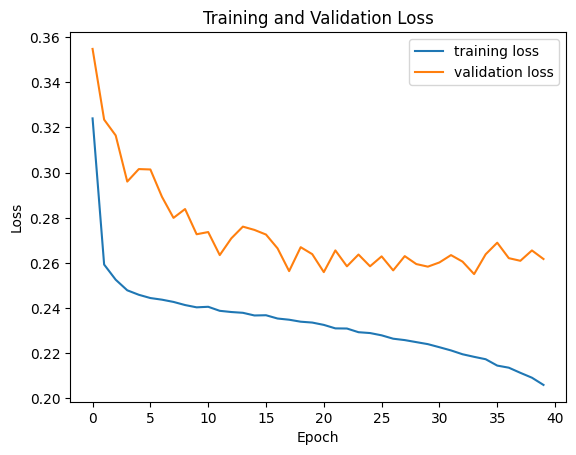

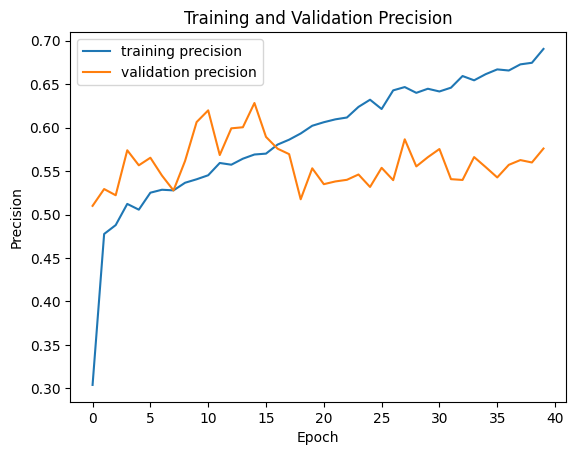

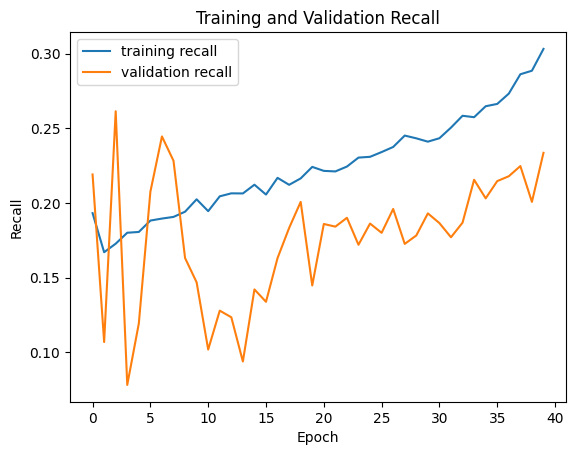

In [13]:
# CodeGrade Tag Ex4a
model.save('/content/checkpoint')
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['precision'], label='training precision')
plt.plot(history.history['val_precision'], label='validation precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training and Validation Precision')
plt.legend()
plt.show()

plt.plot(history.history['recall'], label='training recall')
plt.plot(history.history['val_recall'], label='validation recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Training and Validation Recall')
plt.legend()
plt.show()

**Load the best weights from your model checkpoint, and create plots demonstrating the classification perfomnce of the model. Be sure to demonstrate the results of the multi-label classification, comparing the top three most probable genres predicted with the ground truth genres for each poster. Include these plots in your report, and critically evaluate on the performance of the model across the classes.**

1/1 [==============================] - 0s 17ms/step


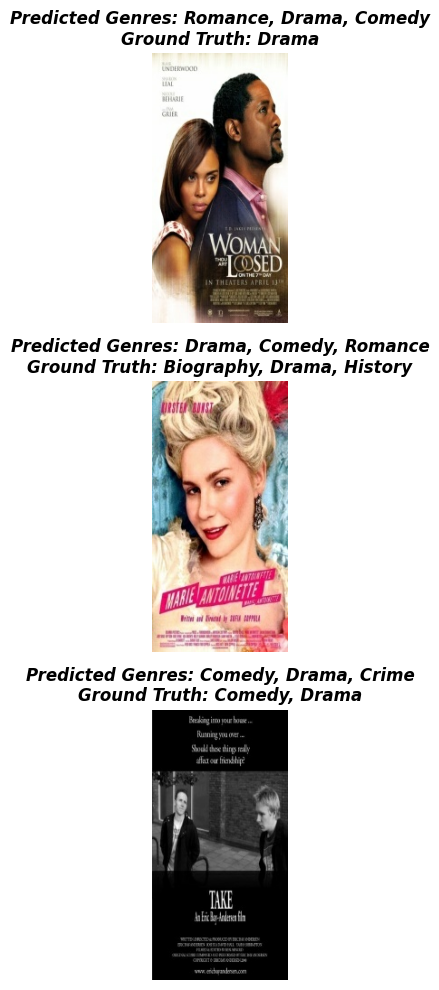

In [15]:
# Load the best weights from the model checkpoint
model.load_weights(checkpoint_filepath)

# Function to predict genres for a given image
def predict_genres(image_path):
    # Read and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, [64, 64])
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.expand_dims(image, axis=0)  # Add batch dimension

    # Predict genres
    predictions = model.predict(image)

    # Get top three predicted genres
    top_three_idx = np.argsort(predictions[0])[-3:][::-1]
    top_three_genres = genres[top_three_idx]

    return top_three_genres

# Function to plot the predicted and ground truth genres for a random sample of images
def plot_predictions(dataset, num_samples=3):
    plt.figure(figsize=(15, 10))
    for i, (image_path, label) in enumerate(dataset.take(num_samples)):
        # Display the image
        plt.subplot(num_samples, 1, i+1)
        img = tf.io.read_file(image_path.numpy().decode('utf-8'))
        img = tf.image.decode_jpeg(img)
        plt.imshow(img)
        plt.axis('off')

        # Display the predicted genres as title
        predicted_genres = predict_genres(image_path.numpy().decode('utf-8'))

        ground_truth_genres = genres[label.numpy() == 1]

        plt.title('Predicted Genres: ' + ', '.join(predicted_genres) + '\nGround Truth: ' + ', '.join(ground_truth_genres), fontsize=12, fontstyle='italic', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Plot predictions for some samples from the test dataset
plot_predictions(test_list_ds)
